In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [5]:
spark = SparkSession.builder.appName("Churn Analysis with Random Forest").getOrCreate()

# Load your dataset
df = spark.read.csv("C:/Users/mural/Downloads/df_clean/df_clean.csv", header=True, inferSchema=True)


In [7]:
# Assume df is your DataFrame
df.printSchema()

# Convert the schema to a more readable table
schema_info = [(field.name, field.dataType, field.nullable) for field in df.schema.fields]

# Create a pandas DataFrame for better display
import pandas as pd

schema_df = pd.DataFrame(schema_info, columns=["Column Name", "Data Type", "Nullable"])

# Display the schema as a table
print(schema_df)


root
 |-- Churn: integer (nullable = true)
 |-- AccountWeeks: integer (nullable = true)
 |-- ContractRenewal: integer (nullable = true)
 |-- DataPlan: integer (nullable = true)
 |-- DataUsage: double (nullable = true)
 |-- CustServCalls: integer (nullable = true)
 |-- DayMins: double (nullable = true)
 |-- DayCalls: integer (nullable = true)
 |-- MonthlyCharge: double (nullable = true)
 |-- OverageFee: double (nullable = true)
 |-- RoamMins: double (nullable = true)

        Column Name      Data Type  Nullable
0             Churn  IntegerType()      True
1      AccountWeeks  IntegerType()      True
2   ContractRenewal  IntegerType()      True
3          DataPlan  IntegerType()      True
4         DataUsage   DoubleType()      True
5     CustServCalls  IntegerType()      True
6           DayMins   DoubleType()      True
7          DayCalls  IntegerType()      True
8     MonthlyCharge   DoubleType()      True
9        OverageFee   DoubleType()      True
10         RoamMins   DoubleType(

In [8]:
# Indexing categorical variables
contract_indexer = StringIndexer(inputCol="ContractRenewal", outputCol="ContractRenewalIndex")
dataplan_indexer = StringIndexer(inputCol="DataPlan", outputCol="DataPlanIndex")

df = contract_indexer.fit(df).transform(df)
df = dataplan_indexer.fit(df).transform(df)


In [9]:
feature_columns = ['AccountWeeks', 'ContractRenewalIndex', 'DataPlanIndex', 'DataUsage', 
                   'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)

# Select features and label
final_data = data.select("features", "Churn")


In [10]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=1234)


In [11]:
rf = RandomForestClassifier(featuresCol='features', labelCol='Churn', numTrees=100)
model = rf.fit(train_data)


In [12]:
predictions = model.transform(test_data)


In [13]:
evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluator for precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision}")

# Evaluator for recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall}")




Accuracy: 0.932475884244373
Precision: 0.9344652588218121
Recall: 0.932475884244373


In [14]:
import pandas as pd

feature_importances = model.featureImportances
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances.toArray()
})
print(feature_importance_df.sort_values(by='Importance', ascending=False))


                Feature  Importance
5               DayMins    0.222875
4         CustServCalls    0.187077
7         MonthlyCharge    0.173582
1  ContractRenewalIndex    0.122415
3             DataUsage    0.076765
9              RoamMins    0.074532
2         DataPlanIndex    0.060920
8            OverageFee    0.058302
0          AccountWeeks    0.013091
6              DayCalls    0.010441


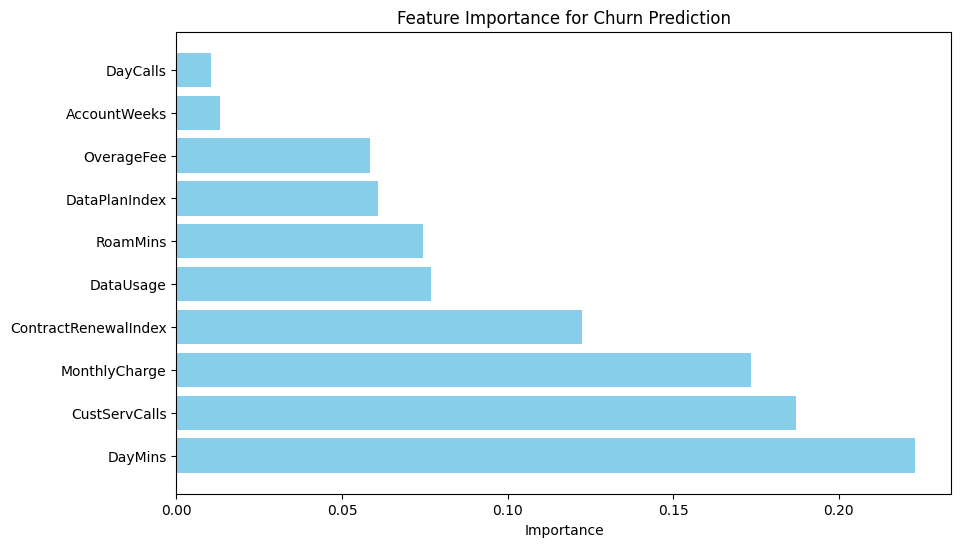

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Convert feature importances to a more visual format
feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Churn Prediction')
plt.show()


+----------------------------+
|corr(DayMins, CustServCalls)|
+----------------------------+
|        -0.01342318635180...|
+----------------------------+

Correlation between DayMins and CustServCalls:
+----------------------------+
|corr(DayMins, CustServCalls)|
+----------------------------+
|        -0.01342318635180...|
+----------------------------+

Correlation between DayMins and MonthlyCharge:
+----------------------------+
|corr(DayMins, MonthlyCharge)|
+----------------------------+
|          0.5679679240679332|
+----------------------------+

Correlation between DayMins and ContractRenewal:
+------------------------------+
|corr(DayMins, ContractRenewal)|
+------------------------------+
|          -0.04939582408518949|
+------------------------------+

Correlation between DayMins and DataUsage:
+------------------------+
|corr(DayMins, DataUsage)|
+------------------------+
|    0.003175951479311...|
+------------------------+

Correlation between DayMins and DataPlan:
+-

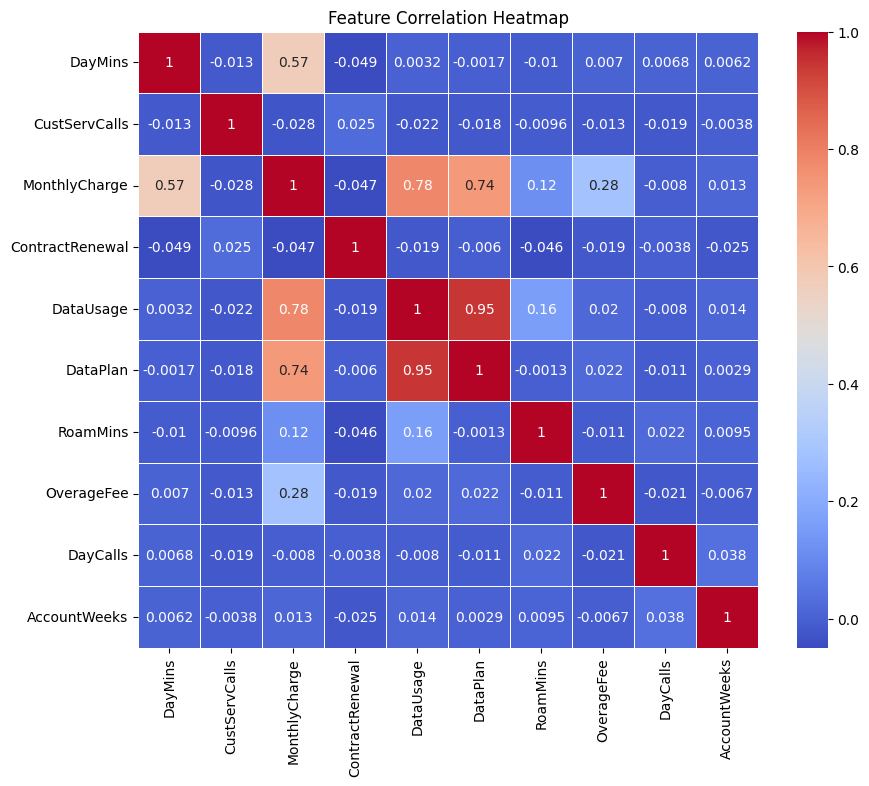

In [18]:
from pyspark.sql.functions import corr

# Compute correlation between 'DayMins' and 'CustServCalls'
df.select(corr("DayMins", "CustServCalls")).show()
columns = ['DayMins', 'CustServCalls', 'MonthlyCharge', 'ContractRenewal', 'DataUsage', 'DataPlan', 'RoamMins', 'OverageFee', 'DayCalls', 'AccountWeeks']

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            print(f"Correlation between {col1} and {col2}:")
            df.select(corr(col1, col2)).show()

# Convert PySpark DataFrame to Pandas for heatmap visualization
pandas_df = df.select(columns).toPandas()

# Generate correlation matrix using pandas
corr_matrix = pandas_df.corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Correlation between Churn and DayMins:  0.20515082926138956
Correlation between Churn and CustServCalls:  0.2087499987837943
Correlation between Churn and MonthlyCharge:  0.07231271096701473
Correlation between Churn and ContractRenewal:  -0.2598518473454817
Correlation between Churn and DataUsage:  -0.08719450893069831
Correlation between Churn and DataPlan:  -0.1021481406701466
Correlation between Churn and RoamMins:  0.06823877562717749
Correlation between Churn and OverageFee:  0.09281242645953196
Correlation between Churn and DayCalls:  0.01845931160857721
Correlation between Churn and AccountWeeks:  0.01654074224367416


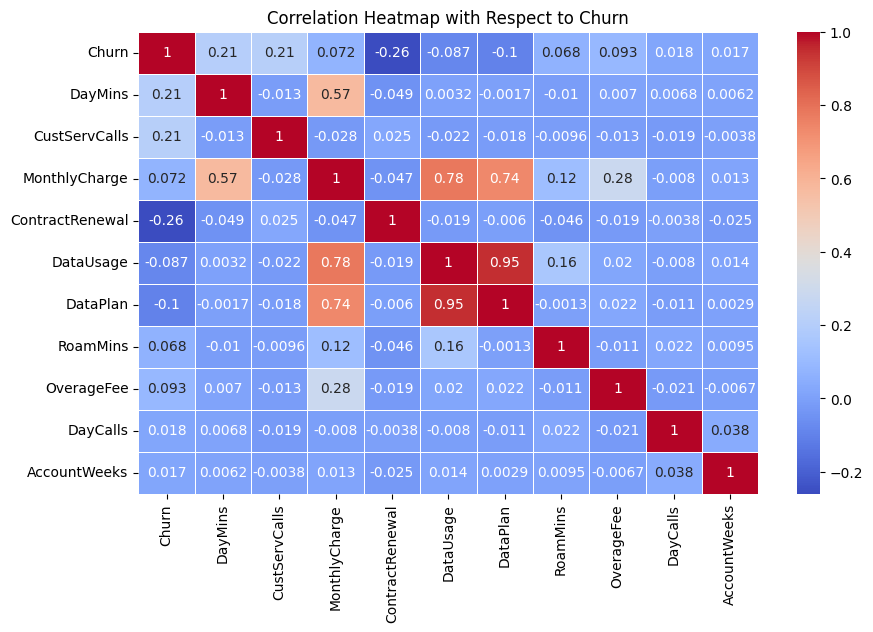

In [20]:
# Importing necessary libraries
from pyspark.sql import SparkSession

# Assuming 'df' is your PySpark DataFrame
# Compute the correlation between churn and another column (example: 'DayMins')
corr_daymins = df.stat.corr('Churn', 'DayMins')
corr_custservcalls = df.stat.corr('Churn', 'CustServCalls')
corr_monthlycharge = df.stat.corr('Churn', 'MonthlyCharge')
corr_contractrenewal = df.stat.corr('Churn', 'ContractRenewal')
corr_datausage = df.stat.corr('Churn', 'DataUsage')
corr_dataplan = df.stat.corr('Churn', 'DataPlan')
corr_roammins = df.stat.corr('Churn', 'RoamMins')
corr_overagefee = df.stat.corr('Churn', 'OverageFee')
corr_daycalls = df.stat.corr('Churn', 'DayCalls')
corr_accountweeks = df.stat.corr('Churn', 'AccountWeeks')

# Print or store the correlations
print("Correlation between Churn and DayMins: ", corr_daymins)
print("Correlation between Churn and CustServCalls: ", corr_custservcalls)
print("Correlation between Churn and MonthlyCharge: ", corr_monthlycharge)
print("Correlation between Churn and ContractRenewal: ", corr_contractrenewal)
print("Correlation between Churn and DataUsage: ", corr_datausage)
print("Correlation between Churn and DataPlan: ", corr_dataplan)
print("Correlation between Churn and RoamMins: ", corr_roammins)
print("Correlation between Churn and OverageFee: ", corr_overagefee)
print("Correlation between Churn and DayCalls: ", corr_daycalls)
print("Correlation between Churn and AccountWeeks: ", corr_accountweeks)

# Assuming your PySpark DataFrame is called 'df'
pandas_df = df.toPandas()  # Convert to Pandas

# Compute the correlation matrix in Pandas
corr_matrix = pandas_df[['Churn', 'DayMins', 'CustServCalls', 'MonthlyCharge', 
                         'ContractRenewal', 'DataUsage', 'DataPlan', 
                         'RoamMins', 'OverageFee', 'DayCalls', 'AccountWeeks']].corr()

# Plotting the heatmap with Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap with Respect to Churn')
plt.show()


In [19]:
# Save the model to a local directory
model.save("file:///C:/Users/mural/OneDrive/Desktop/SEM5/bde/model")


In [21]:
parquet_file_path = "C:/Users/mural/OneDrive/Desktop/SEM5/bde/model/data/part-00000-6500fd5b-c7cd-45ca-82f4-dea94213f416-c000.snappy.parquet"
data_df = spark.read.parquet(parquet_file_path)

# Show the contents to understand its structure (optional)
data_df.show()

# Save the DataFrame to CSV
csv_file_path = "C:/Users/mural/OneDrive/Desktop/SEM5/bde/output"  # Update with your desired output path
data_df.write.mode("overwrite").csv(csv_file_path, header=True)

# Stop the Spark session
spark.stop()

Py4JJavaError: An error occurred while calling o467.parquet.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2702)
	at org.apache.spark.sql.execution.datasources.SchemaMergeUtils$.mergeSchemasInParallel(SchemaMergeUtils.scala:63)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.mergeSchemasInParallel(ParquetFileFormat.scala:497)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetUtils$.inferSchema(ParquetUtils.scala:132)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.inferSchema(ParquetFileFormat.scala:79)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$getOrInferFileFormatSchema$11(DataSource.scala:208)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:205)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:407)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:563)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
